#### - Обучить AE собственной архитектуры на MNIST
#### - Обучить VAE собственной архитектуры на MNIST

In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
import numpy as np                   
from torch.utils.data import DataLoader        
from torchvision.utils import make_grid        
import matplotlib.pyplot as plt                
import torch.optim as optim                    

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])

train_set = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False, num_workers=4)

test_set = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)

C:\Users\Katya\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(True))

        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(16,6,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,1,kernel_size=5),
            nn.ReLU(True),
            nn.Sigmoid())

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
num_epochs = 5
batch_size = 128
model = Autoencoder().cpu()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

In [6]:
%%time
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = Variable(img).cpu()

        output = model(img)
        loss = distance(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/5], loss:0.9752
epoch [2/5], loss:0.9749
epoch [3/5], loss:0.9749
epoch [4/5], loss:0.9749
epoch [5/5], loss:0.9749
Wall time: 6min 18s


In [7]:
test = test_set.data[784].unsqueeze(0).unsqueeze(0).float() / 255
predict = model(test)

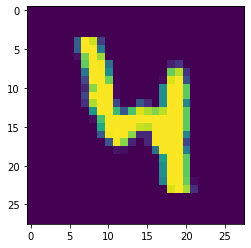

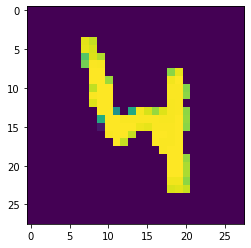

In [8]:
plt.imshow(test[0].view(28, 28).detach().numpy())
plt.show()

plt.imshow(predict[0][0].cpu().detach().numpy())
plt.show()

### - Обучить VAE собственной архитектуры на MNIST

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
batch_size = 100      
L = 1                 
e_hidden = 500        
d_hidden = 500        
latent_dim = 2        
learning_rate = 0.001 
weight_decay = 1e-5   
epochs = 10          

In [11]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc
        self.N.scale = self.N.scale
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z      

In [12]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [13]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [14]:
torch.manual_seed(0)
d = 4
vae = VariationalAutoencoder(latent_dims=d)
lr = 1e-3 
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)
vae.to(device)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [15]:
def train_epoch(vae, device, dataloader, optimizer):

    vae.train()
    train_loss = 0.0

    for x, _ in dataloader: 

        x = x.to(device)
        x_hat = vae(x)

        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [16]:
def test_epoch(vae, device, dataloader):

    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): 
        for x, _ in dataloader:
            x = x.to(device)
            encoded_data = vae.encoder(x)
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [17]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,device,train_loader,optim)
    val_loss = test_epoch(vae,device,test_loader)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))


 EPOCH 1/10 	 train loss 546.953 	 val loss 495.965

 EPOCH 2/10 	 train loss 478.019 	 val loss 484.618

 EPOCH 3/10 	 train loss 472.320 	 val loss 481.328

 EPOCH 4/10 	 train loss 469.252 	 val loss 479.019

 EPOCH 5/10 	 train loss 467.158 	 val loss 475.384

 EPOCH 6/10 	 train loss 465.628 	 val loss 476.685

 EPOCH 7/10 	 train loss 464.310 	 val loss 473.100

 EPOCH 8/10 	 train loss 463.256 	 val loss 473.320

 EPOCH 9/10 	 train loss 462.413 	 val loss 472.083

 EPOCH 10/10 	 train loss 461.540 	 val loss 470.496


In [24]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_set.targets.numpy()
    t_idx = {i:targets[i] for i in range(10)}
    
    for i in range(n):
        
        ax = plt.subplot(2,n,i+1)
        img = test_set[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(img))

        plt.imshow(img.cpu().squeeze().numpy())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Input')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy())  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Output')
            
    plt.show()  

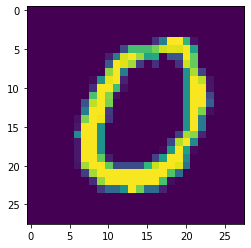

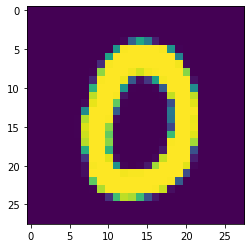

In [19]:
test = test_set.data[981].unsqueeze(0).unsqueeze(0).float() / 255
predict = vae(test)

plt.imshow(test[0].view(28, 28).detach().numpy())
plt.show()

plt.imshow(predict[0][0].cpu().detach().numpy())
plt.show()

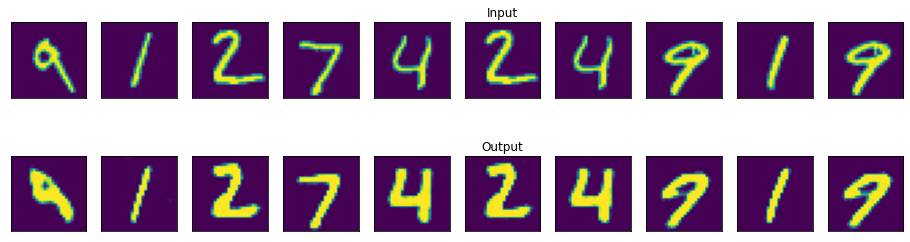

In [25]:
plot_ae_outputs(vae.encoder,vae.decoder,n=10)